# Computer Vision CSCI-GA.2272-001 Assignment 1, part 2.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction
This assignment requires you to participate in a Kaggle competition with the rest of the class on the The German Traffic Sign Recognition Benchmark [http://benchmark.ini.rub.de/?section=gtsrb&subsection=news]. The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2021/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file gtsrb_kaggle.csv that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
You should make a copy of this Colab (File->Save a copy in Drive). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is not allowed! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.
Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

### Important Details
• You are only allowed eight (8) submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 0.95. 

• *Extra important:* Please use your NYU NetID as your Kaggle username, so the TAs can figure out which user you are on the leaderboard. 


# Dataset Preparation


1.  Download `dataset.zip` from to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders (`training,validation,testing`). 
3.  Go to Google Drive (on your NYU account) and make a directory `assign2_dataset` (New button --> New Folder).
4.  Upload each of the three subfolders to it (New button --> Folder upload). 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/assign2_dataset/

Mounted at /content/drive
/content/drive/My Drive/assign2_dataset


# Dataloader

In [3]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device("cuda:0")

batch_size = 32
momentum = 0.9
lr = 0.01
epochs = 30
log_interval = 100

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TestData(Dataset):
  def __init__(self,path):
    self.test=torch.load(path).squeeze(1)
  def __len__(self):
    return self.test.size(0)
  def __getitem__(self, idx):
      return self.test[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")
test_dataset = TestData(path='testing/test.pt')

test_loader=torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# **Model Construction**
The model is constructed by three convolutional sequential block and one linear fully connected block with two fully connected hidden layers.

In three convolutional blocks:

1. I used ReLU function as activation function since ReLU function doesn't activate all neurons at the same time which helps speed up model convergence(Fergus 2021). 
2. I applied the batch normalization directly before the ReLU function(which is non-linearity).Since the batch normalization reduces the need of Dropout and effectively prevents the model from the saturating non-linearities, I deleted the Dropout in convolutional blocks.
3. In the previous 2 convolutional blocks with less complex output channels, I set the pooling layers with thw filter 2*2; however, in the third convolutional block, I changed the filter size into 4*4. Correspondingly, I expected each filter can obtain more features and highlight the most significant feature, and let output down sampled before the linear hidden layers.
4. The last sequential block is combined with two linear hidden layers.
---



The Model Structure:

0. Input  (3, 32, 32) 
1. Convolutional (50, 32, 32) kernel = 5*5, padding = 2
2. BatchNorm (50, 32, 32)
3. ReLU (50, 32, 32)
4. Max-Pooling (50, 16, 16) kernel = 2*2
5. Convolutional (250, 16, 16) kernel = 3*3, padding = 1
6. BatchNorm (250, 16, 16)
7. ReLU (250, 16, 16)
8. Max-Pooling (250, 8, 8) kernel = 2*2
9. Convolutional (500, 8, 8) kernel = 3*3, padding = 1
10. BatchNorm (500, 8, 8)
11. ReLU (500, 8, 8)
12. Max-Pooling (500, 2, 2) kernel = 4*4
13. Dropout (500, 2, 2)
14. Flatten (1, 2000)
15. Fully connected 500 neurons
16. BatchNorm (1,500)
17. ReLU 500 neurons
18. Dropout
19. Fully connected 43 neurons
20. Log softmax

---






In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=5,padding=2)
        # self.bn1=nn.BatchNorm2d(32)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        # self.bn2=nn.BatchNorm2d(64)
        
        # self.conv3= nn.Conv2d(64, 128, kernel_size=3,padding=1)
        # self.bn3=nn.BatchNorm2d(128)
        # self.conv3_drop = nn.Dropout2d()
        # # self.conv2_drop = nn.Dropout2d()
        # self.fc1 = nn.Linear(512, 64)
        # self.fc2 = nn.Linear(64,nclasses)
        # # self.fc2 = nn.Linear(4000, 1000)
        # # self.fc3 = nn.Linear(1000, nclasses)

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.BatchNorm2d(50),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # [b, 50, 16, 16]
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(50, 250, kernel_size=3, padding=1),
            nn.BatchNorm2d(250),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # [b, 250, 8, 8]
        )
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(64, 128, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), # [b, 250, 4, 4]
        #     nn.Dropout2d()
        # )
        self.conv3 = nn.Sequential(#stride = 4
            nn.Conv2d(250, 500, kernel_size=3, padding=1),
            nn.BatchNorm2d(500),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=4), # [b, 500, 2, 2]
            nn.Dropout2d()
        )
        # ----------------------------didn't use⬇️----------------------
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # [b, 128, 2, 2]
            
        )
         # ----------------------------didn't use ⬆️----------------------
        self.fc_block = nn.Sequential(
            nn.Linear(2000, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(500, 43)
        )
        # self.fc_block = nn.Sequential(
        #     nn.Linear(512, 512 // 16, bias=False),
        #     nn.BatchNorm1d(512//16),
        #     nn.ReLU(),
        #     nn.Linear(512//16, 512, bias=False),
        #     nn.Sigmoid(),
        #     nn.BatchNorm1d(512),
        #     nn.ReLU(),
        #     nn.Dropout(p=0.5),
        #     nn.Linear(512, 43)
        # )
            
        
        
        
    def forward(self, x):
        #x.shape = 32(batch size) * 3*32*32

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # x = self.conv4(x)
        x = x.view(-1, 2000)
        # x = self.SE(x)
        x = self.fc_block(x)

        

        
        
        # m6:
        # x = self.conv1(x)
        
        # x = F.max_pool2d(F.relu(x),2)
        # x = self.bn1(x)
        # x = self.conv2(x)
        
        # x = F.max_pool2d(F.relu(x),2)
        # x = self.bn2(x)
        # x = self.conv3(x)
        
        # x = F.max_pool2d(F.relu(x),2)
        # x = self.bn3(x)
        # x = self.conv3_drop(x)

        #m4/m7:
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = self.bn1(x)
        # x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # x = self.bn2(x)
        # x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        # x = self.bn3(x)

#m8
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = self.bn1(x)
        # x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # x = self.bn2(x)
        # x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 4))
        # x = self.bn3(x)
        # --------------------------
        
        # x = F.relu(self.conv1(x))
        # x = self.bn1(x)
        # x = F.max_pool2d(x,2)
        
        # x = F.relu(self.conv2(x))
        # x = self.bn2(x)
        # x = F.max_pool2d(x,2)
        # x = F.relu(self.conv3(x))
        # x = self.bn3(x)
        # x = F.max_pool2d(x,2)
#FCN-------------------
        # x=x.view(-1,512)
        # x = self.fc1(x)
        # x = self.fc2(x)
#--------------------


        # x = self.fc2(x)
        # x = self.fc3(x)
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = x.view(-1, 500)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        
        return F.log_softmax(x,dim=1)


# **Training Net: optimizer with weight decay**
Referring to Krogh and Hertz's finding, a simple weight decay can add static noise on targets which helps model improve generalization ability (956). Therefore, I directly set the value of weight_decay in torch.optim.SGD function (weight_decay=5e-4). The optimizer will update after each epoch under the additional restriction by weight_decay.




In [5]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=5e-4)

def train(epoch):
    model.train()
    correct = 0
    tra_loss=0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data=data.to(device)
        target=target.to(device)
        output = model(data)
        
        loss = F.nll_loss(output, target)
        tra_loss+=loss
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        loss.backward()
        optimizer.step()
    train_accuracy.append("{:.0%}".format(correct/len(train_loader.dataset)))
    train_loss.append(tra_loss/len(train_loader.dataset))
      
        

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data=data.to(device)
        target=target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    val_loss.append(validation_loss)
    accuracy.append("{:.0%}".format(correct/len(val_loader.dataset)))
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

epochs = 50
train_loss=[]
val_loss=[]
accuracy=[]
train_accuracy=[]
for epoch in range(1, epochs+1):
    train(epoch)
    validation()
    model_file = 'model_conv50_f_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')
print(accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Validation set: Average loss: 0.5176, Accuracy: 3339/3870 (86%)


Saved model to model_conv50_f_1.pth.

Validation set: Average loss: 0.2802, Accuracy: 3560/3870 (92%)


Saved model to model_conv50_f_2.pth.

Validation set: Average loss: 0.2190, Accuracy: 3621/3870 (94%)


Saved model to model_conv50_f_3.pth.

Validation set: Average loss: 0.1450, Accuracy: 3704/3870 (96%)


Saved model to model_conv50_f_4.pth.

Validation set: Average loss: 0.1711, Accuracy: 3680/3870 (95%)


Saved model to model_conv50_f_5.pth.

Validation set: Average loss: 0.1657, Accuracy: 3700/3870 (96%)


Saved model to model_conv50_f_6.pth.

Validation set: Average loss: 0.1289, Accuracy: 3725/3870 (96%)


Saved model to model_conv50_f_7.pth.

Validation set: Average loss: 0.1282, Accuracy: 3731/3870 (96%)


Saved model to model_conv50_f_8.pth.

Validation set: Average loss: 0.1291, Accuracy: 3733/3870 (96%)


Saved model to model_conv50_f_9.pth.

Validation set: Average loss: 0.1184, Accuracy: 3736/3870 (97%)

**Plot Loss for each epoch**

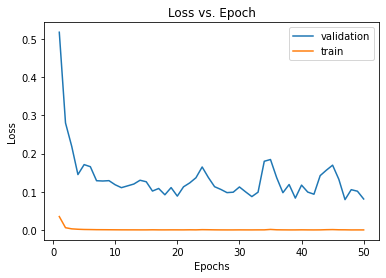

In [6]:
import matplotlib.pyplot as plt
plt.title('Loss vs. Epoch')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot([i for i in range(1,epochs+1)],val_loss,label="validation")
plt.plot([i for i in range(1,epochs+1)],train_loss,label="train")
plt.legend()
plt.show()


**Plot Accuracy for each epoch**

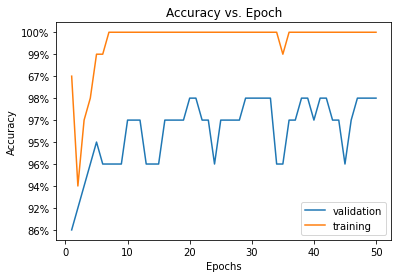

In [7]:
import matplotlib.pyplot as plt
plt.title('Accuracy vs. Epoch')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot([i for i in range(1,epochs+1)],accuracy,label="validation")
plt.plot([i for i in range(1,epochs+1)],train_accuracy,label="training")
plt.legend()
plt.show()

# Evaluate
Referring to the bagging ensemble strategy, instead of generating single predictor, we could create several predictors, and then combine the outputs of different base predictors (Ganaie et al. 5). I selected several good models which have been trained after different indepent training process and have comparatively excellent validation performances. Then I use those models to predict test Data indepently. For each test data , I will use the highest prediction result among those models as the final prediction output. That little trick has successfully contributed to a slight 0.07% accuracy improvement. This trick also promotes me to further apply a complete and precise ensemble strategy to further projects.

In [8]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}
# model_32=Net1().to(device)
# model_32.load_state_dict(torch.load('model_conv32_21.pth'))
# model_32.eval()
test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model1 = Net().to(device) # TODO: load your model here, don't forget to put it on Eval mode !
#what coding written here?
# model1.load_state_dict(torch.load('model_conv50_30.pth'))
model1.load_state_dict(torch.load('model_conv50_b_26.pth'))
model1.eval()
model2 = Net().to(device)
model2.load_state_dict(torch.load('model_conv50_b_27.pth'))
model2.eval()
# model3 = Net().to(device)
# model3.load_state_dict(torch.load('model_conv50_b_28.pth'))
# model3.eval()
model4 = Net().to(device)
model4.load_state_dict(torch.load('model_conv50_b_29.pth'))
model4.eval()
# model5 = Net().to(device)
# model5.load_state_dict(torch.load('model_conv50_b_24.pth'))
# model5.eval()
# model6 = Net().to(device)
# model6.load_state_dict(torch.load('model_conv50_b_25.pth'))
# model6.eval()
model7 = Net().to(device)
model7.load_state_dict(torch.load('model_conv50_30.pth'))
model7.eval()
model8 = Net().to(device)
model8.load_state_dict(torch.load('model_conv50_c_46.pth'))#99%
model8.eval()
model9 = Net().to(device)
model9.load_state_dict(torch.load('model_conv50_c_48.pth'))#3809
model9.eval()
model10 = Net().to(device)
model10.load_state_dict(torch.load('model_conv50_c_38.pth'))#3806
model10.eval()
modelA=Net().to(device)
modelA.load_state_dict(torch.load('model_conv50_e_31.pth'))
modelA.eval()
modelB=Net().to(device)
modelB.load_state_dict(torch.load('model_conv50_e_48.pth'))
modelB.eval()
modelC=Net().to(device)
modelC.load_state_dict(torch.load('model_conv50_e_50.pth'))
modelC.eval()



for i, (data) in enumerate(test_data):
    data = data.unsqueeze(0)
    data = data.to(device)
    # ouput8 = model8(data)
    output8 = model8(data)
    output9 = model9(data)
    pred8 = output8.data.max(1, keepdim=True)[1].item()
    pred9 = output9.data.max(1, keepdim=True)[1].item()
    outputB = modelB(data)
    predB = outputB.data.max(1, keepdim=True)[1].item()
    outputC = modelC(data)
    predC = outputC.data.max(1, keepdim=True)[1].item()
    outputA = modelA(data)
    predA = outputA.data.max(1, keepdim=True)[1].item()

    # output4 = model4(data)
    # pred4 = output4.data.max(1, keepdim=True)[1].item()
    # output5 = model5(data)
    # pred5 = output5.data.max(1, keepdim=True)[1].item()
    # output6 = model6(data)
    # pred6 = output6.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    pred=max(predA,predB)
    dataframe_dict['ClassId'].append(predB)
# 
    # if pred1>=pred2:
    #   dataframe_dict['ClassId'].append(pred1)
    # else:
    #   dataframe_dict['ClassId'].append(pred2)
      

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now take this csv file, download it from your Google drive and then submit it to Kaggle to check performance of your model.

# Past several training attempts:
1. 4 convolutional layers. I assumed to deepen hidden layers by adding one additional conv layer. I set the channels: 3-->32--->64--->128--->128. However, the valiation prediction accuracy reached a upper limit bound about 97% with slight fluctuation. Therefore, I thought 4 conv layers may draw model to drop some important features when an input goes deeper in the network.
2. Referring to SE-Net, I tried to reconstruct the fully connected layer: using two multi-layer perception to strengthen the connections among feature maps, and then using sigmoid activation function to highlight the important features (Hu et al. 3-4). However, the structure didn't properly fit my training model and contributed a little.
3. Previously, I used 3--->32--->64---->128 channels transformation in the convolutional blocks, and found that 3--->50---->250----->500 got a better predictio performance.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # [b, 32, 16, 16]
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # [b, 64, 8, 8]
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # [b, 128, 2, 2]
            nn.Dropout2d()
        )
        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(128, 128, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=2, stride=2), # [b, 128, 2, 2]
            
        # )
        self.fc_block = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 43)
        )
    def forward(self, x):
        #x.shape = 32(batch size) * 3*32*32

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # x = self.conv4(x)
        x = x.view(-1, 512)
        x = self.fc_block(x)
        return F.log_softmax(x,dim=1)

In [ ]:
model0 = Net1().to(device)

optimizer = optim.SGD(model0.parameters(), lr=lr, momentum=momentum,weight_decay=5e-4)
# optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4, amsgrad=False)
# sched=lambda epoch: (1-epoch/epochs)**0/95
# scheduler=torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda=sched)
def train(epoch):
    model0.train()
    correct = 0
    tra_loss=0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data=data.to(device)
        target=target.to(device)
        output = model0(data)
        loss = F.nll_loss(output, target)
        tra_loss+=loss
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        loss.backward()
        optimizer.step()
    train_accuracy.append("{:.0%}".format(correct/len(train_loader.dataset)))
    train_loss.append(tra_loss/len(train_loader.dataset))
      
        

def validation():
    model0.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data=data.to(device)
        target=target.to(device)
        output = model0(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    val_loss.append(validation_loss)
    accuracy.append("{:.0%}".format(correct/len(val_loader.dataset)))
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


train_loss=[]
val_loss=[]
accuracy=[]
train_accuracy=[]
for epoch in range(1, epochs+1):
    train(epoch)
    validation()
    model_file = 'model_conv32_' + str(epoch) + '.pth'
    torch.save(model0.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')
print(accuracy)



# Reference
1.   Fergus, Miller, Puhrsch (2021) Neural Networks [PowerPoint Presentation]
2. Fergus, Miller, Puhrsch (2021) Convolutional Networks [PowerPoint Presentation]
2.   Ioffe, Sergey, and Szegedy, Chistian (2015) Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift [arXiv:1502.03167]
3. M.A. Ganaie et al. (2021) Ensemble deep learning: A review [arXiv:2104.02395]
4. Krogh, Anders et al. (1991) A simple weight decay can improve generalization [Morgan Kaufmann Publishers Inc.]



